This notebook was used for the [M5 Forecasting - Accuracy](https://www.kaggle.com/c/m5-forecasting-accuracy) competition on Kaggle. I have teamed up with two other users, and we worked on this project for approximately 3 months. 

The goal is to predict future sales of different stores in the US, based on past data. There were a lot of variables to take into account: day of the year, location of the stores, type of product sold, selling price, etc. We have tried several type of models and have created many features to improve our score.

Although our result were surprinsingly disappointing regarding the time we have spent on that competition, I have learnt a lot in that period, not only regarding pure Machine Learning, but also on a human plan by working with other people and planning our work.

# 1. Loading Data

In [1]:
import numpy as np 
import pandas as pd 
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/evaluation-algreko-loading-the-data/m5_eval_test_data.pkl
/kaggle/input/evaluation-algreko-loading-the-data/__results__.html
/kaggle/input/evaluation-algreko-loading-the-data/__notebook__.ipynb
/kaggle/input/evaluation-algreko-loading-the-data/m5_eval_data.pkl
/kaggle/input/evaluation-algreko-loading-the-data/custom.css
/kaggle/input/evaluation-algreko-loading-the-data/__output__.json


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

## 1.2 Loading data grid

We've merged the several datasets into a single grid and loaded it directly, in order to improve the speed of execution of our notebook. This grid gathers all the information made available by the M5 team, and was saved as a pickle to make it lighter to save and load.

In [3]:
print('Loading the data...')
DATA_GRID_INPUT_DIR = '../input/evaluation-algreko-loading-the-data'
data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_eval_data.pkl')

Loading the data...


## 1.3 Init variables

In [4]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
1,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
2,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
3,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961
4,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46881672,FOODS_3_825_WI_3_evaluation,3046,6,9,2,2,d_1941,2.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.980469
46881673,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1940,1.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273
46881674,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1941,0.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273
46881675,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1940,5.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000


In [5]:
h = 28 # Prediction horizon
max_lags = 65 # Max lags used
TRAINING_LAST_DAY_NUM = 1941 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
FIRST_LOADING_DAY = datetime(2013, 4,7) # First day for training
SEED = 7


# 2. Feature Engineering

## Creating features

We have chosen to keep only time-related and lag features for our model. We have tried to create many others, but as their impact on the results was not clear, we have decided not to include them in the final model.

In [6]:
def create_features(df):
    lags = [7,28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)
               
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }
    

    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
    

In [7]:
%%time
create_features(data)

CPU times: user 4min 29s, sys: 23.4 s, total: 4min 52s
Wall time: 4min 52s


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46881677 entries, 0 to 46881676
Data columns (total 33 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   item_id             int16         
 2   dept_id             int8          
 3   store_id            int8          
 4   cat_id              int8          
 5   state_id            int8          
 6   d                   object        
 7   sales               float16       
 8   date                datetime64[ns]
 9   wm_yr_wk            int16         
 10  weekday             int8          
 11  wday                int16         
 12  month               int16         
 13  year                int16         
 14  event_name_1        int8          
 15  event_type_1        int8          
 16  event_name_2        int8          
 17  event_type_2        int8          
 18  snap_CA             float16       
 19  snap_TX             float16       
 20  

In [9]:
data.dropna(inplace = True)
data.shape

(45082767, 33)

The dataset had more than 45 million rows, and was really long to process through our algorithm. It slowed a lot our investigation.

In [10]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
713989,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_60,0.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,1.142578,0.928711,3.572266,0.433838,0.967773,13,1,29
713990,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_61,0.0,2011-03-30,11109,6,5,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,0.285645,0.714355,3.572266,0.433350,0.969238,13,1,30
713991,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_62,0.0,2011-03-31,11109,4,6,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,0.000000,0.643066,3.427734,0.432617,0.970703,13,1,31
713992,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_63,0.0,2011-04-01,11109,0,7,4,2011,0,0,0,0,1.0,1.0,0.0,0.419922,0.0,0.0,0.000000,0.000000,0.643066,3.214844,0.431885,0.972168,13,2,1
713996,HOBBIES_1_009_CA_1_evaluation,8,0,0,0,0,d_60,2.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,1.769531,9.0,0.0,2.000000,1.571289,2.250000,2.035156,1.597656,1.107422,13,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46881672,FOODS_3_825_WI_3_evaluation,3046,6,9,2,2,d_1941,2.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.980469,1.0,0.0,1.142578,0.571289,0.714355,0.893066,3.980469,1.000000,20,2,22
46881673,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1940,1.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,1.0,1.000000,0.856934,1.142578,0.964355,1.280273,1.000000,20,2,21
46881674,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,d_1941,0.0,2016-05-22,11617,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,3.0,1.000000,1.142578,1.142578,0.928711,1.280273,1.000000,20,2,22
46881675,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1940,5.0,2016-05-21,11617,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000,2.0,0.0,0.714355,0.000000,0.571289,1.250000,1.000000,1.000000,20,2,21


## Reduce mem usage of created features

In [11]:
data = reduce_mem_usage(data)

Mem. usage decreased to 3353.55 Mb (6.0% reduction)


In [12]:
gc.collect()

80

# 3. Fit & Predict

In [13]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 3.516455826 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
713989,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_60,0.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,1.142578,0.928711,3.572266,0.433838,0.967773,13,1,29
713990,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_61,0.0,2011-03-30,11109,6,5,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,0.285645,0.714355,3.572266,0.433350,0.969238,13,1,30
713991,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_62,0.0,2011-03-31,11109,4,6,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,0.000000,0.643066,3.427734,0.432617,0.970703,13,1,31
713992,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_63,0.0,2011-04-01,11109,0,7,4,2011,0,0,0,0,1.0,1.0,0.0,0.419922,0.0,0.0,0.0,0.000000,0.643066,3.214844,0.431885,0.972168,13,2,1
713996,HOBBIES_1_009_CA_1_evaluation,8,0,0,0,0,d_60,2.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,1.769531,9.0,0.0,2.0,1.571289,2.250000,2.035156,1.597656,1.107422,13,1,29


In [14]:
valid_start = datetime(2016, 4, 25)
train_valid_end_dt = datetime(2016, 5, 22)

In [15]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weights"]
train_cols = data.columns[~data.columns.isin(useless_cols)]

X_train = data[train_cols]
y_train = data["sales"]

X_valid= data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), train_cols]
y_valid = data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), "sales"]
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=cat_feats, free_raw_data=False)


del data, X_train, y_train 

gc.collect()

CPU times: user 1.95 s, sys: 893 ms, total: 2.84 s
Wall time: 2.84 s


0

In [16]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1300,
            'boost_from_average': False,
            'verbose': 1,
            'seed': SEED,
} 

In [17]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data],verbose_eval=50)

[50]	training's rmse: 2.73799	valid_1's rmse: 2.24002
[100]	training's rmse: 2.49623	valid_1's rmse: 2.04399
[150]	training's rmse: 2.44771	valid_1's rmse: 2.01643
[200]	training's rmse: 2.41431	valid_1's rmse: 2.00167
[250]	training's rmse: 2.39197	valid_1's rmse: 1.99153
[300]	training's rmse: 2.37644	valid_1's rmse: 1.98389
[350]	training's rmse: 2.36373	valid_1's rmse: 1.97761
[400]	training's rmse: 2.35242	valid_1's rmse: 1.97202
[450]	training's rmse: 2.34241	valid_1's rmse: 1.96762
[500]	training's rmse: 2.33353	valid_1's rmse: 1.96389
[550]	training's rmse: 2.32501	valid_1's rmse: 1.95987
[600]	training's rmse: 2.31704	valid_1's rmse: 1.9564
[650]	training's rmse: 2.31022	valid_1's rmse: 1.95318
[700]	training's rmse: 2.30331	valid_1's rmse: 1.95006
[750]	training's rmse: 2.29719	valid_1's rmse: 1.94715
[800]	training's rmse: 2.29135	valid_1's rmse: 1.9443
[850]	training's rmse: 2.28576	valid_1's rmse: 1.9416
[900]	training's rmse: 2.28023	valid_1's rmse: 1.93901
[950]	training

After trying several models, we have opted for a LGB model with a Tweedie loss, as the sales were heavily right-skewed because of the presence of items which aren't bought for many days. This improved a lot our score! The other parameters mostly come from iterations, we have tried to submit hundreds of different models.

We see that the training period took six hours to be completed!

In [18]:
print("Training complete")

Training complete


In [19]:
# m_lgb.save_model(f'{DATA_GRID_INPUT_DIR}/evaluation_model.lgb')
# m_lgb = lgb.Booster(model_file=f'{DATA_GRID_INPUT_DIR}/evaluation_model.lgb')

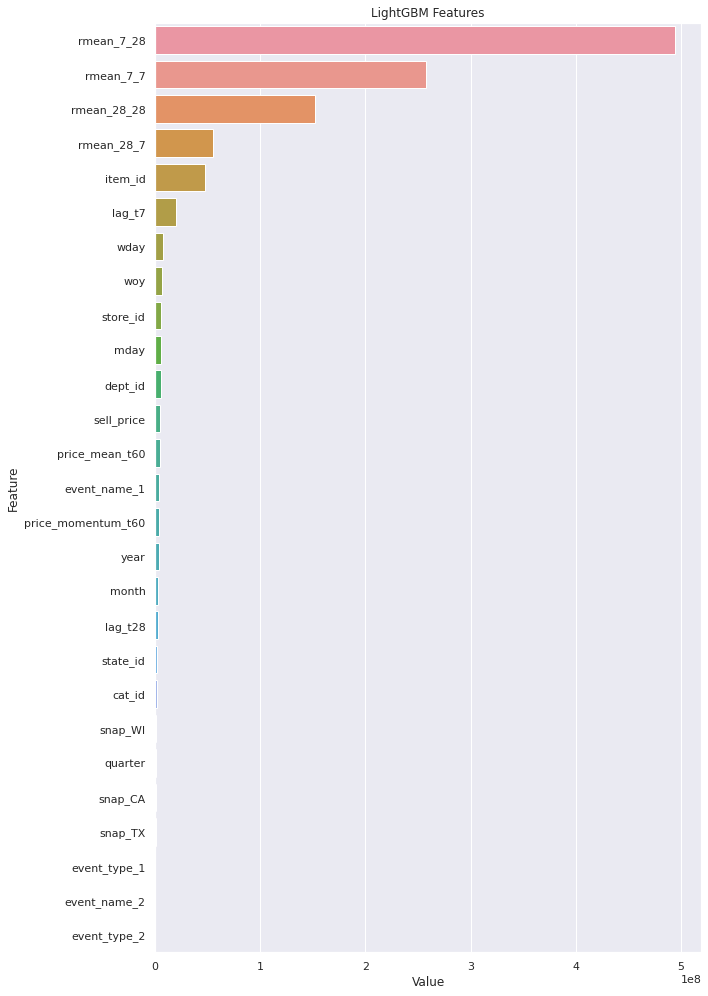

In [20]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance("gain"), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

By looking at the features importance of the model, we saw how much our lag features were helpful to predict future sales: a sudden change in price or a high-sales period can indeed influence a lot the future sales. The item sold itself (feature *item_id*) was also really important, becaus each item had its own sales pattern.

In [21]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
20,4.945515e+08,rmean_7_28
18,2.575555e+08,rmean_7_7
21,1.525670e+08,rmean_28_28
19,5.527578e+07,rmean_28_7
0,4.771821e+07,item_id
16,1.991563e+07,lag_t7
5,8.045112e+06,wday
24,6.908988e+06,woy
2,5.855414e+06,store_id
26,5.848938e+06,mday


In [22]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_eval_test_data.pkl')

CPU times: user 533 ms, sys: 87.7 ms, total: 621 ms
Wall time: 628 ms


In [23]:
def create_lag_features_for_test(df, day):
    # create lag feaures just for single day (faster)
    lags = [7,28]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main

    windows = [7,28]
    for window in windows:
        for lag in lags:
            df_window = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+window))]
            df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{window}"] = df_window_grouped.sales.values     
    
    
## Creating features for test data
def create_date_features_for_test(df):
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")
            
    # Create price features
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)


In [24]:
create_date_features_for_test(tdata)

In [25]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    tdata.loc[tdata.date == day, "sales"] =m_lgb.predict(tst) 

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 28min 30s, sys: 2 s, total: 28min 32s
Wall time: 7min 44s


In order to deal with the lag features, our predictions was made by a "day-by-day" model, where we create on-the-go the lag features, taking into account our sales prediction to compute them. Its creation was quite complex but we've managed to do it!

In [26]:
print("say Prediction complete")

say Prediction complete


In [27]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id                    149003
item_id               149003
dept_id               149003
store_id              149003
cat_id                149003
state_id              149003
d                     149003
sales                 149003
date                  149003
wm_yr_wk              149003
weekday               149003
wday                  149003
month                 149003
year                  149003
event_name_1          149003
event_type_1          149003
event_name_2          149003
event_type_2          149003
snap_CA               149003
snap_TX               149003
snap_WI               149003
sell_price            149003
woy                   149003
quarter               149003
mday                  149003
price_mean_t60         37501
price_momentum_t60     37501
dtype: int64

In [28]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)


tdata_sub.to_csv("evaluation_submission.csv",index=False)
tdata_sub.shape

CPU times: user 4.96 s, sys: 78.8 ms, total: 5.04 s
Wall time: 5 s


(30490, 29)

Finally, some post-processing was needed in order to submit our predictions. 